# Proposal Method

In [2]:
import sys
import json
import random
import cPickle
import numpy as np
import paddle.v2 as paddle

In [3]:
def load_video(video_id, path='/mnt/BROAD-datasets/video/training/'):
    
    with open(path+video_id+'.pkl', 'rb') as f:
        data = cPickle.load(f)
    video_length = data.shape[0]
    return data, video_length

In [4]:
def load_labels(json_path='/mnt/BROAD-datasets/video/meta.json'):
    with open(json_path, 'r') as f:
        json_content = json.load(f)
    return json_content

In [5]:
def load_train_video(video_id, labels):
    data, video_length = load_video(video_id)
    annotations = labels['database'][video_id]['annotations']
    label = np.zeros([video_length])
    for point in points:
        label[int(point[0]):int(point[1])] = 1
    return data, label, video_length
    

In [6]:
def generate_segments(video, label, window_size=10, stride=5, thresh=3):
    """
    分段
    """
    segments = [] # (data, label_forward, label_backward)
    video_length = len(video)
    num_segments = (video_length - window_size + stride) / stride
    start = 0
    for i in xrange(num_segments):
        segment = video[start: start+window_size]
        current_label = label[start: start+window_size]
        start += stride
        
        if np.sum(current_label) > thresh:
            label = 1
        else:
            label = 0
            
#         forward_label = np.zeros([window_size])
#         backward_label = np.zeros([window_size])
#         k = 0
#         while k < window_size and current_label[k] != 0:
#             k += 1
#             forward_label[k] = 1
        
#         k = window_size-1
#         while k >= 0 and current_label[k] != 0:
#             k = k - 1
#             backward_label[k] = 1
        segments.append((segment, label))
    return segments


In [7]:
def create_reader():
    
#     with open('data.txt', 'r') as f:
#         file_names = f.readlines()
#     file_names = [x.rstrip('\n\r').replace('.pkl', '') for x in file_names]
#     labels = load_labels()
#     all_data = []
#     for name in file_names:
#         data, label, video_length = load_train_video(name, labels)
#         segments = generate_segments(data, label)
#         all_data = all_data.extend(segments)
    
    def reader():
        # random.shuffle(all_data)
        for i in xrange(1000):#len(all_data)):
            yield np.random.rand(1,2048), np.random.randint(0,2)#np.array(all_data[i][0]), int(all_data[i][1])
            
    return reader

In [8]:
def model(batch_input_seq):
    
    bidirectional_gru = paddle.networks.bidirectional_gru(
        input=batch_input_seq,
        size=512,
        return_seq=True
    )    
    
    fc_1 = paddle.layer.fc(
        input=bidirectional_gru,
        size=256,
        act=paddle.activation.Relu()
    )
    
    gru2 = paddle.networks.bidirectional_gru(
        input=fc_1,
        size=256,
    )
    output = paddle.layer.fc(
        input=gru2,
        size=2,
        act=paddle.activation.Softmax()
    )
    return output
    

In [9]:
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title, test_title)
step = 0
sum_cost = 0.0

In [10]:
input_data = paddle.layer.data(name='data', type=paddle.data_type.dense_vector_sequence(2048))
is_train = True
output = model(input_data)

In [ ]:
paddle.init(use_gpu=False, trainer_count=2)

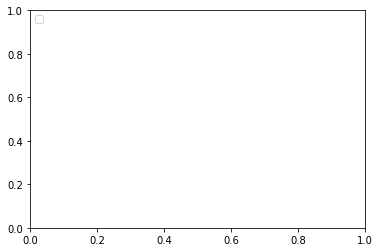

In [ ]:
if is_train:
    input_label = paddle.layer.data(name='label', type=paddle.data_type.integer_value(2))
    cost = paddle.layer.classification_cost(input=output, label=input_label)
    train_reader = create_reader()
    train_reader = paddle.batch(reader=train_reader,batch_size=64)
    feeding = {'data':0, 'label':1}
    adam_optimizer = paddle.optimizer.Adam(learning_rate=1e-4,
        regularization=paddle.optimizer.L2Regularization(rate=8e-4),
        model_average=paddle.optimizer.ModelAverage(average_window=0.5))
    parameters = paddle.parameters.create(cost)
    trainer = paddle.trainer.SGD(cost=cost,parameters=parameters,update_equation=adam_optimizer)
    
    def event_handler(event):
        global step
        global sum_cost
        
        if isinstance(event, paddle.event.EndIteration):
            sum_cost += event.cost
            if step % 10 == 0:  # every 10 batches, record a train cost
                cost_ploter.append(train_title, step, event.cost)
            if event.batch_id % 20 == 0:
                print "\nPass %d, Batch %d, AVG_COST: %f, %s" % (
                    event.pass_id, event.batch_id, sum_cost/(event.batch_id+1), event.metrics)
            else:
                sys.stdout.write('.')
                sys.stdout.flush()
        if isinstance(event, paddle.event.EndPass):
            sum_cost = 0.0
            with open('/home/kesci/work/params.tar', 'w') as f:
                parameters.to_tar(f)
        if step % 100 == 0:
            cost_ploter.plot()
        step += 1
    
    trainer.train(reader=train_reader,event_handler=event_handler,feeding=feeding,num_passes=10)
    

In [3]:
def nms_detection(proposals, scores, overlap=0.7):
    """Non-maximum suppression: Greedily select high-scoring detections and
    skip detections that are significantly covered by a previously selected
    detection. This version is translated from Matlab code by Tomasz
    Malisiewicz, who sped up Pedro Felzenszwalb's code.
    Parameters
    ----------
    props : ndarray
        Two-dimensional array of shape (num_props, 2), containing the start and
        end boundaries of the temporal proposals.
    scores : ndarray
        One-dimensional array of shape (num_props,), containing the corresponding
        scores for each detection above.
    Returns
    -------
    nms_props, nms_scores : ndarrays
        Arrays with the same number of dimensions as the original input, but
        with only the proposals selected after non-maximum suppression.
    """
    t1 = props[:, 0]
    t2 = props[:, 1]
    ind = np.argsort(scores)
    area = (t2 - t1 + 1).astype(float)
    pick = []
    while len(ind) > 0:
        i = ind[-1]
        pick.append(i)
        ind = ind[:-1]
        tt1 = np.maximum(t1[i], t1[ind])
        tt2 = np.minimum(t2[i], t2[ind])
        wh = np.maximum(0., tt2 - tt1 + 1.0)
        o = wh / (area[i] + area[ind] - wh)
        ind = ind[np.nonzero(o <= overlap)[0]]
    nms_props, nms_scores = props[pick, :], scores[pick]
    return nms_props, nms_scores
    

In [1]:
def inference(video_id, parameters):
    
    video, video_length = load_video(video_id, '/mnt/BROAD-datasets/video/testing/')
    
    segments = []
    window_size = 10
    num_segments = video_length/window_size
    start = 0
    for i in xrange(num_segments):
        segment = video[start: start+window_size]
        start += window_size
        segments.append((segment,))
    
    probs = paddle.infer(output_layer=output, parameters=parameters, input=segments, feeding={'data': 0})
    
    return probs
    

In [10]:
def aggregate(prediction, probs):
    window_size = 10
    # result: [((start, end),prob),....]
    result = []
    
    current_start = -1
    current_end = 0
    # 间隔空白
    blank_threshhold = 2
    # 最小长度
    min_lengths = 1
    
    state = 0
    # state = 0 未找到start
    # state = 1 找到start，未找到end, 当前值为1
    # state = 2 找到start，未找到end, 当前值为0
    # state = 3 中间隔了很多空白

    for i in xrange(prediction.shape[0]):
        if state == 0 and prediction[i] == 1:
            
            current_start = i
            state = 1
            continue
            
        if state == 1 and prediction[i] == 1:
            
            current_end = i
            continue
        
        if state == 1 and prediction[i] == 0:
            
            state = 2
            continue
        
        if state == 2 and prediction[i] == 1:
            
            distance = i - current_end
            if distance > blank_threshhold:
                
                length = current_end - current_start + 1
                state = 0
                if length <= min_lengths:
                    current_start = -1
                    current_end = -1
                    continue
                prob = sum(probs[current_start: current_end+1])/length
                result.append(([current_start*window_size, current_end*window_size],prob))
                current_start = -1
                current_end = -1
                continue
            else:
                
                if distance < blank_threshhold/2:
                    current_end = i
                    state = 1
                    continue
                else:
                    state = 3
                    continue
                    
        if state == 3 and prediction[i] == 1:
            current_end = i
            state = 1
            continue
        
        if state == 3 and prediction[i] == 0:
            
            length = current_end - current_start + 1

            state = 0
            if length <= min_lengths:
                current_start = -1
                current_end = -1
                continue
            prob = sum(probs[current_start: current_end+1])/length
            result.append(([current_start*window_size, current_end*window_size],prob))

            current_start = -1
            current_end = -1
            continue
    
    if state == 1 and current_start != -1:
        current_end = len(prediction)
        length = current_end - current_start + 1
        if length <= min_lengths:
            current_start = -1
            current_end = -1
            return result
        prob = sum(probs[current_start: current_end+1])/length
        result.append(([current_start*window_size, current_end*window_size],prob))

    return result


In [3]:
def generate_result(probs):
    prediction = np.argmax(prrob, axis=1)
    predict_right_prob = prrob[:,1]
    data = aggregate(prediction, predict_right_prob)
    return data

In [7]:
def inference_all():
    infer_result = dict()
    counter = 0
    
    with open('/home/kesci/work/params.tar', 'r') as f:
        parameters = paddle.parameters.Parameters.from_tar(f)

    infer_result = dict()
    counter = 0
    for video_file in test_files_lines:
        video_id = video_file.split('.')[0]
        prob = inference(video_id, parameters)
        infer_result[video_id] = prob
        counter += 1
        print("[%s/%s]finish: %s" % (counter, len(test_files_lines), video_id))
    return infer_result

In [5]:
def post_handle(infer_result):
    result = dict()
    for key in probs.keys():
        prrob = probs[key]
        data = generate_result(prrob)
        result[key] = data
    return result


In [8]:
def generate_result_file(data, filepath, version='VERSION 1.0'):
    result = dict()
    result['version'] = version
    
    results = dict()
    
    for key in data.keys():
        
        tmp_result = []
        for seg in data[key]:
            tmp_dict = dict()
            tmp_dict['score'] = seg[1]
            tmp_dict['segment'] = seg[0]
            tmp_result.append(tmp_dict)
        results[key] = tmp_result
    
    result['results'] = results
    
    r = json.dumps(result)
    print(r)
    with open(filepath, 'w+') as f:
        f.write(r)
    print("generate finished")

In [9]:
in_result = inference_all()
print("Finish Inference")
result = post_handle(in_result)
print("Finish Post Handle")
generate_result_file(result, 'v2.json')
print("Finish Genenrate")
    